# ML for Time Series

## A Unified Framework for Structured Graph Learning via Spectral Constraints

Baptiste Collet - Cyril Miras

## Experiments

### Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from learnGraphTopology import *

## Gene dataset

This dataset come from https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#

It represents 801 patients with cancers of 5 different types

The features of the data are RNA-Seq gene expression levels

The label is the tumor type

To make the code work, download the dataset,extract it and save data and labels in the folder ./data/genes/

In [2]:
gene_df = pd.read_csv("data/genes/data.csv")
gene_df = gene_df[gene_df.columns[1:]]
gene_df

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [23]:
gene_labels = pd.read_csv("data/genes/labels.csv")
gene_labels = gene_labels[gene_labels.columns[1:]]
gene_labels

,Class
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA
...,...
796,BRCA
797,LUAD
798,COAD
799,PRAD


The goal is to model the distribution with a $k$ component graph, in order to clusetr the data into $k$ classes. As there are $k=5$ classes in reality, we try the algorithm with this value.

In [3]:
C = np.cov(gene_df.values)

In [39]:
res = learn_k_component_graph(C, k=5, maxiter=2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [29:12<00:00,  1.14it/s]


Then, we reorganise the matrix according to their labels to see visually if the components that should be connected are effectively connected.

In [33]:
idx = np.argsort(gene_labels.values.squeeze())

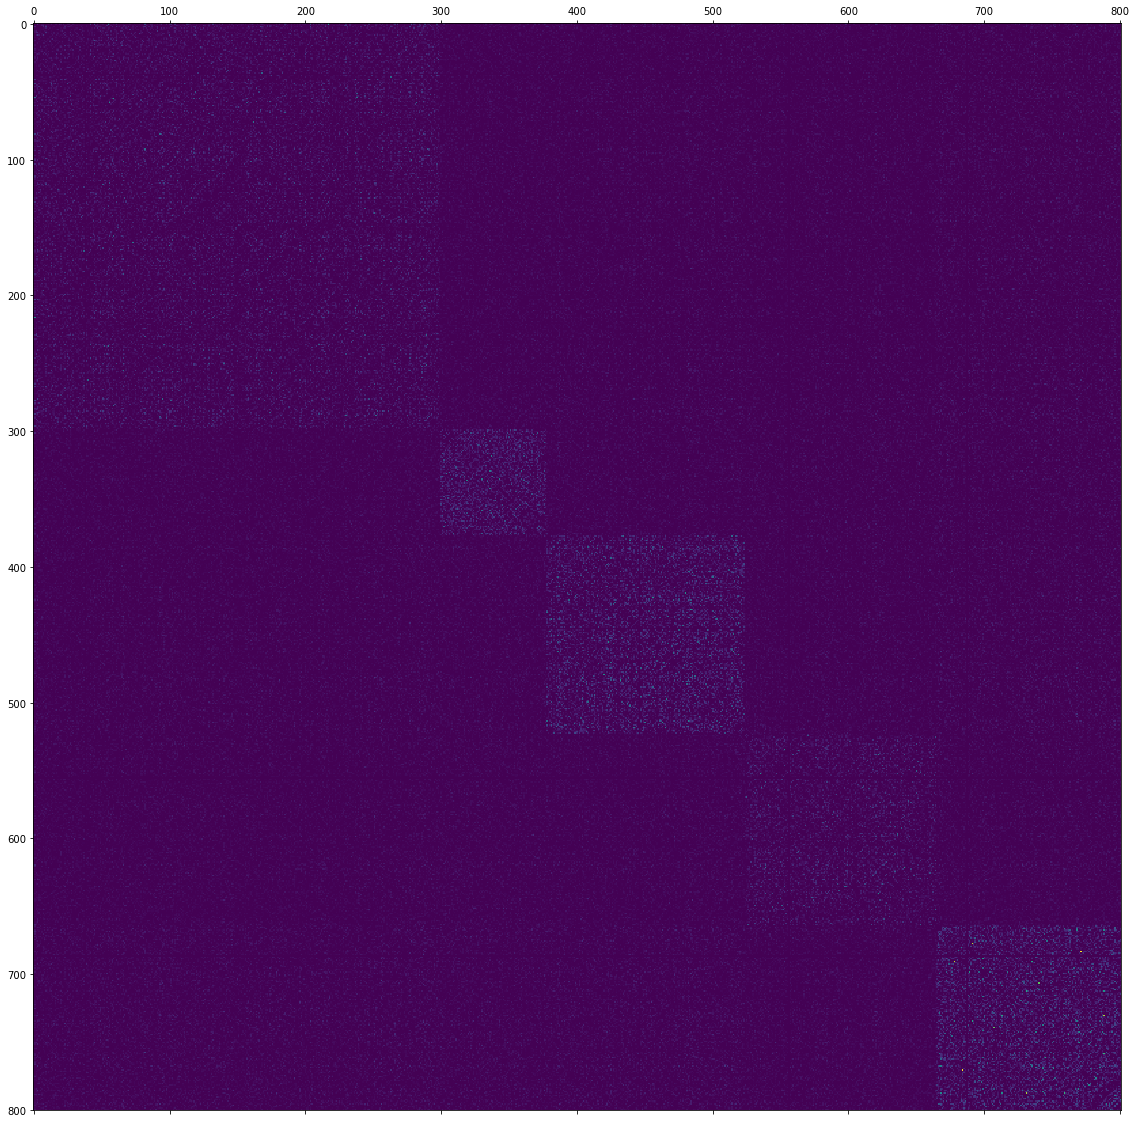

In [36]:
fig = plt.figure(figsize=(20, 20))
plt.matshow(res["Adjacency"][idx][:, idx], fignum=0)
plt.show()

In [38]:
print(np.sort(np.linalg.eig(res["Laplacian"])[0]))

[4.19803081e-15 2.06091518e-02 3.03019128e-02 3.84991366e-02
 6.00615262e-02 8.30680934e+00 8.47899025e+00 8.60259249e+00
 9.11056958e+00 9.17795459e+00 9.24359467e+00 9.32080173e+00
 9.40577849e+00 9.42224121e+00 9.46309748e+00 9.53832184e+00
 9.54568614e+00 9.68010706e+00 9.72774767e+00 9.74073751e+00
 9.76321093e+00 9.76720439e+00 9.86986031e+00 9.92742567e+00
 1.00078244e+01 1.01478030e+01 1.02769402e+01 1.03358487e+01
 1.03743878e+01 1.04051286e+01 1.05090121e+01 1.06118934e+01
 1.06850189e+01 1.07031630e+01 1.07250389e+01 1.07707457e+01
 1.08500646e+01 1.08951171e+01 1.09362959e+01 1.09509317e+01
 1.09563298e+01 1.10058792e+01 1.10506097e+01 1.10885449e+01
 1.11392474e+01 1.11747956e+01 1.11922456e+01 1.12256310e+01
 1.12822726e+01 1.12991004e+01 1.13156627e+01 1.13876931e+01
 1.14265513e+01 1.14585472e+01 1.14878410e+01 1.15144732e+01
 1.15471312e+01 1.15577422e+01 1.15866227e+01 1.15992130e+01
 1.16152524e+01 1.16288293e+01 1.16397278e+01 1.16702203e+01
 1.16880013e+01 1.170396